In [0]:
#Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

#NLP
import nltk
from nltk import sent_tokenize, word_tokenize, RegexpParser
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tag import pos_tag

#Machine Learning
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

#WordCloud
from wordcloud import WordCloud

In [2]:
#Download resource
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [0]:
"""
        Preprocessing text for TfidfVectorizer
          - remove non-character
          - tokenization
          - stopword removal
          - lemmatization
        Parameters
        ----------
        reviews : list
             reviews of customer in hospital
        Return
        ----------
        cleaned_reviews : list
             Preprocessed Reviews  
"""
def preprocess_review(reviews): 
    cleaned_reviews = []
    for review in reviews:
        review = re.sub("[^a-zA-Z]", " ", review)
        words = word_tokenize(review) 
        tokenized_words = [word.lower() for word in words if word not in stopwords.words("english")]
        lemmatized_word = lemmatize_word(tokenized_words)
        cleaned_reviews.append(lemmatized_word)
    return cleaned_reviews

In [0]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'a'

In [0]:
def lemmatize_word(tokenized_words): 
    lemmatizer = WordNetLemmatizer() 
    lemmatized_words = []
    for word, tag in pos_tag(tokenized_words):
        pos = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    lemmatized_words = ' '.join([str(word) for word in lemmatized_words]) 
    return lemmatized_words

In [0]:
def extract_sentences(df):
  sentences = []
  scores = [] 
  cids = [] 
  for cid in df["cid"]:
    en = df.loc[cid, "review"]
    score = df.loc[cid, "rating"]
    s = sent_tokenize(en)
    sentences = sentences + s
    scores = scores + [score]*len(s)
    cids = cids + [cid] * len(s) 
  return pd.DataFrame({"reviews": sentences, "ratings": scores, "cids": cids})

In [0]:
def multinomial_nb_classify(X_train, X_test, y_train, y_test):
    kfold = StratifiedKFold( n_splits = 5, random_state = 2020 )
    tfidf_vectorizer = TfidfVectorizer()
    multinomial_nb_clf = MultinomialNB()
    multinomial_naive_bayes_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', multinomial_nb_clf)
    ])
    multinomial_naive_bayes_params = {}
    grid = GridSearchCV(multinomial_naive_bayes_pipeline, param_grid = multinomial_naive_bayes_params, cv = kfold, scoring = 'roc_auc')
    grid.fit(X_train, y_train)
     
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [0]:
def random_forest_classify(X_train, X_test, y_train, y_test):
    kfold = StratifiedKFold( n_splits = 5, random_state = 2020 )
    tfidf_vectorizer = TfidfVectorizer()
    rf_clf =  RandomForestClassifier(random_state=2020, class_weight="balanced")
    rf_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', rf_clf)
    ])
    rf_params = {
        "classifier__n_estimators": range(50, 200, 50),
        "classifier__max_depth": range(2, 10, 2), 
        "classifier__min_samples_leaf": range(1, 4)
    }
    grid = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=kfold, scoring='roc_auc')
    grid.fit(X_train, y_train) 
    
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [0]:
def svm_classify(X_train, X_test, y_train, y_test):
    kfold = StratifiedKFold( n_splits = 5, random_state = 2020 )
    tfidf_vectorizer = TfidfVectorizer()
    svm_clf =  SVC(random_state=2020, class_weight="balanced", probability=True)
    svm_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', svm_clf)
    ])
    svm_params = {
        "classifier__C": [ 0.1, 0.5, 1, 5, 10 ],
        "classifier__gamma": np.arange(0.1,1,0.1)
    }
    grid = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=kfold, scoring='roc_auc')
    grid.fit(X_train, y_train) 
    
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [0]:
def predict_sentiment(estimator, df):
  sentiments = []
  for sentence in df["reviews"]: 
    sentiment = estimator.predict([sentence])
    if sentiment == 1:
      sentiment = "positive"
    else:
      sentiment = "negative"
    sentiments.append( sentiment ) 
  return sentiments

In [0]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  else:
    return word

In [0]:
def groups(word):
    if word in ("doctor", "nurse", "student"):
        return "staff"
    elif word in ("hospital", "clinic", "equipment", "place"):
        return "infrastructure"
    elif word in ("service", "care", "treatment", "surgery", "disease", "medical care"):
        return "service"
    elif word in ("queue", "appointment"):
        return "process"
    elif word in ("price", "claim"):
        return "finance"
    else:
        return "others"

In [0]:
def create_parsed_trees(df):
  grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""
  chunker = RegexpParser(grammar)
  parse_trees = []
  for sentence in df['reviews']:
      parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))
  return parse_trees

In [0]:
def extract_noun_phrases(parsed_trees):
    nps = []
    for parsed_tree in parsed_trees:
      np = []
      for subtree in parsed_tree.subtrees():
          if subtree.label() == 'NP':
              t = subtree
              t = " ".join(word for word, tag in t.leaves())
              np.append(t)
      nps.append(np)
    return nps

In [0]:
def vizwordcloud(df, colormap = 'viridis'):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud(width=1000,height=800,colormap=colormap,max_words=100).generate_from_frequencies(dict(tuples))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [0]:
def get_positive_data(df):
  pos = df[df["sentiments"] == "positive"].reset_index(drop=True)
  pos_words = sum(pos["NP"].tolist(), [])
  pos_words = [word.lower() for word in pos_words]
  pos_words = [plural2singular(word) for word in pos_words]
  poshist = pd.DataFrame({"words": pos_words})
  poshist = poshist.groupby("words").size().reset_index(name="#pos")
  return poshist

In [0]:
def get_negative_data(df):
  neg = df[df["sentiments"] == "negative"].reset_index(drop=True)
  neg_words = sum(neg["NP"].tolist(), [])
  neg_words = [word.lower() for word in neg_words]
  neg_words = [plural2singular(word) for word in neg_words]
  neghist = pd.DataFrame({"words": neg_words})
  neghist = neghist.groupby("words").size().reset_index(name="#neg")
  return neghist

# Bumrungrad Hospital

In [0]:
bumrungrad = pd.read_csv("bumrungrad-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
bumrungrad = bumrungrad.reset_index()
bumrungrad = bumrungrad.rename(columns={"index": "cid"})
bumrungrad = extract_sentences(bumrungrad) 
bumrungrad["cleaned_reviews"] = preprocess_review(bumrungrad["reviews"])

In [0]:
X = bumrungrad["cleaned_review"]
y = bumrungrad["ratings"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2020)

**Multinomial Naive Bayes**

In [18]:
multinomial_nb_classify(X_train, X_test, y_train, y_test)

Best Score : 0.73
Best Params : 
{}
Accuracy : 0.88
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.88      1.00      0.93       164

    accuracy                           0.88       187
   macro avg       0.44      0.50      0.47       187
weighted avg       0.77      0.88      0.82       187



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

**Random Forest**

In [19]:
random_forest_classify(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best Score : 0.73
Best Params : 
{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50}
Accuracy : 0.89
              precision    recall  f1-score   support

           0       0.75      0.13      0.22        23
           1       0.89      0.99      0.94       164

    accuracy                           0.89       187
   macro avg       0.82      0.56      0.58       187
weighted avg       0.87      0.89      0.85       187



Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                  

**Support Vector Machine**

In [20]:
svm_classifier = svm_classify(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best Score : 0.79
Best Params : 
{'classifier__C': 1, 'classifier__gamma': 0.30000000000000004}
Accuracy : 0.89
              precision    recall  f1-score   support

           0       0.54      0.61      0.57        23
           1       0.94      0.93      0.94       164

    accuracy                           0.89       187
   macro avg       0.74      0.77      0.75       187
weighted avg       0.89      0.89      0.89       187



In [25]:
svm_classifier

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     de

In [0]:
bumrungrad["sentiments"] = predict_sentiment(svm_classifier, bumrungrad)

In [0]:
bumrungrad["NP"] = extract_noun_phrases(create_parsed_trees(bumrungrad))

In [45]:
bumrungrad

,reviews,ratings,cids,cleaned_review,sentiments,NP
0,Hospitals are very well behaved.,1,0,hospital well behave,positive,[Hospitals]
1,There's a very good doctor patient.,1,0,there good doctor patient,positive,[doctor patient]
2,"Nurses do not bother me face cafeteria clean, ...",1,0,nurse bother face cafeteria clean good front i...,positive,"[Nurses, clean, front, diameter]"
3,The Banco vaccine and the detection of allergi...,1,0,the banco vaccine detection allergy child,positive,"[vaccine, detection, allergies, children]"
4,This treatment is here The X-ray machines thro...,1,0,this treatment the x ray machine modern expert...,positive,"[treatment, machines, Experts, boy, food]"
...,...,...,...,...,...,...
616,I thought to myself I did not know it.,0,231,i think i know,negative,[]
617,The nurse noted that this was not very friendly.,0,231,the nurse note friendly,positive,[nurse]
618,I took my wife to the doctor on my time.,0,231,i take wife doctor time,negative,"[wife, doctor, time]"
619,"Wait very long at first, but before the foreig...",0,231,wait long first foreigner arrive unexpectedly ...,positive,[foreigners]


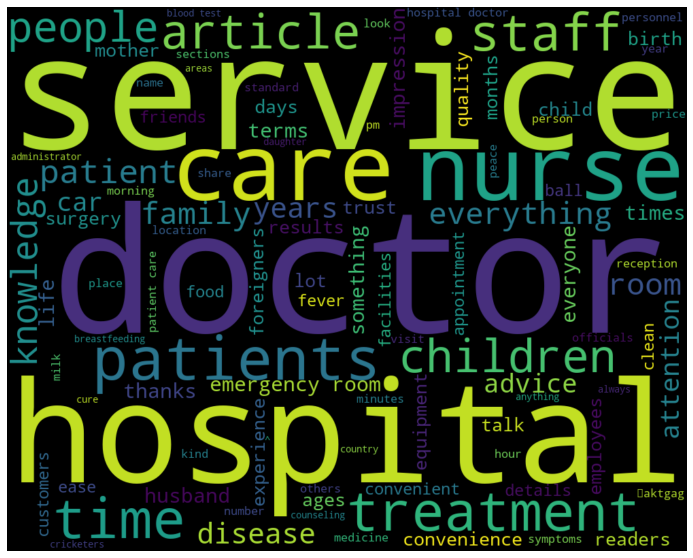

In [90]:
bumrungrad_positive = get_positive_data(bumrungrad)
vizwordcloud(bumrungrad_positive)

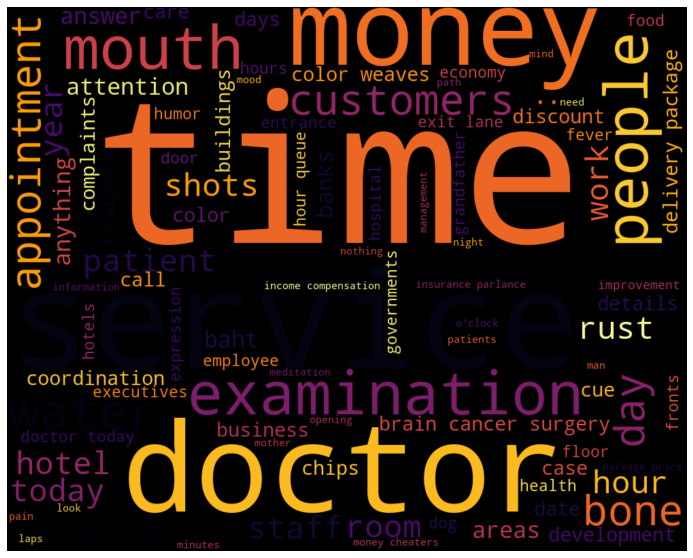

In [91]:
bumrungrad_negative = get_negative_data(bumrungrad)
vizwordcloud(bumrungrad_negative, "inferno")

# Lerdsin Hospital

In [0]:
lerdsin = pd.read_csv("lerdsin-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
lerdsin = lerdsin.reset_index()
lerdsin = lerdsin.rename(columns={"index": "cid"})
lerdsin = extract_sentences(lerdsin) 
lerdsin["cleaned_reviews"] = preprocess_review(lerdsin["reviews"])

In [0]:
lerdsin["sentiments"] = predict_sentiment(svm_classifier, lerdsin)

In [0]:
lerdsin["NP"] = extract_noun_phrases(create_parsed_trees(lerdsin))

In [47]:
lerdsin

,reviews,ratings,cids,cleaned_reviews,sentiments,NP
0,I can't remember which year it was at the end ...,1,0,i remember year end year,positive,"[year, end, year]"
1,At that time we were hemorrhoids.,1,0,at time hemorrhoid,negative,"[time, hemorrhoids]"
2,Do not dare to see a doctor because of fear of...,1,0,do dare see doctor fear treatment hurt and emb...,positive,"[doctor, fear, treatment, butt, others, person..."
3,Looking at our trembling fears when knowing th...,1,0,look tremble fear know need commit read inform...,positive,"[fears, information, web, treatment]"
4,He said it was a lethal disease.,1,0,he say lethal disease,positive,[disease]
...,...,...,...,...,...,...
1458,Orthopedic oncology professor Dr. Piya honor S...,1,395,orthopedic oncology professor dr piya honor se...,positive,"[oncology professor, department]"
1459,"Care and counseling is very good, including a ...",1,395,care counsel good include pep talk fear diseas...,positive,"[counseling, pep talk, disease, patients]"
1460,Doctors caring for patients with very good siz...,1,396,doctor care patient good size patient doctor s...,positive,"[Doctors, patients, size, doctor, face, person..."
1461,Excellent Service,1,397,excellent service,positive,[]


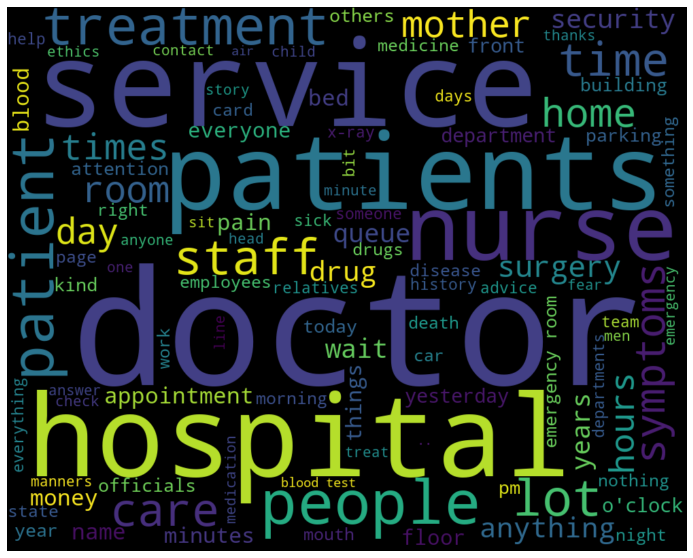

In [92]:
lerdsin_positive = get_positive_data(lerdsin)
vizwordcloud(lerdsin_positive)

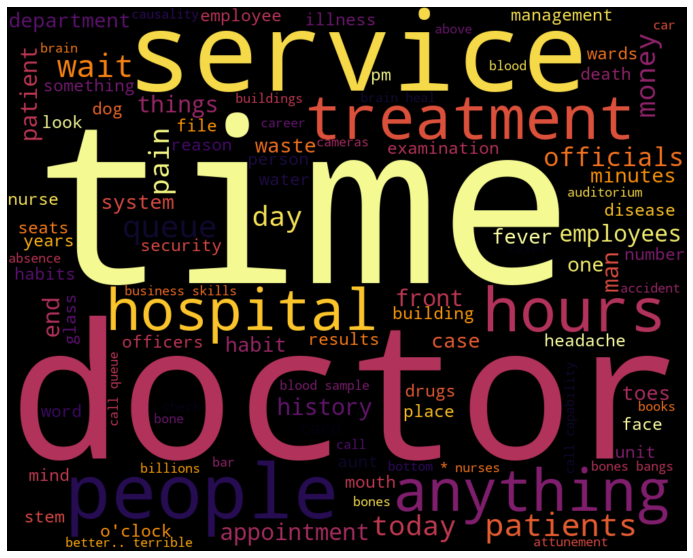

In [93]:
lerdsin_negative = get_negative_data(lerdsin)
vizwordcloud(lerdsin_negative, "inferno")

# Rajavithi Hospital

In [0]:
rajavithi = pd.read_csv("rajavithi-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
rajavithi = rajavithi.reset_index()
rajavithi = rajavithi.rename(columns={"index": "cid"})
rajavithi = extract_sentences(rajavithi) 
rajavithi["cleaned_reviews"] = preprocess_review(rajavithi["reviews"])

In [0]:
rajavithi["sentiments"] = predict_sentiment(svm_classifier, rajavithi)

In [0]:
rajavithi["NP"] = extract_noun_phrases(create_parsed_trees(rajavithi))

In [49]:
rajavithi

,reviews,ratings,cids,cleaned_reviews,sentiments,NP
0,Hospital beautiful atmosphere with cool air.,1,0,hospital beautiful atmosphere cool air,positive,"[beautiful, air]"
1,To ease Hospital staffs all very nice to me si...,1,0,to ease hospital staff nice since,positive,[staffs]
2,It is recommended that people wait to fill out...,1,0,it recommend people wait fill new patient i know,negative,"[people, patient]"
3,What to do in the next step.,1,0,what next step,positive,[step]
4,Which floor to go to the doctor As I reached t...,1,0,which floor go doctor as i reach front check wait,positive,"[floor, doctor, front, check]"
...,...,...,...,...,...,...
544,(Perhaps the realization itself) consult on al...,1,139,perhaps realization consult matter,positive,"[realization, consult, matters]"
545,Even non-disease treatment The examination of ...,1,139,even non disease treatment the examination pat...,positive,"[treatment, examination, patient, lunch break]"
546,You never leave the patient gets to eat.,1,139,you never leave patient get eat,positive,[patient]
547,Check out each day to patients than the patien...,1,139,check day patient patient pm it nearly pm you ...,negative,"[day, patients, patients, pm, pm, lunch]"


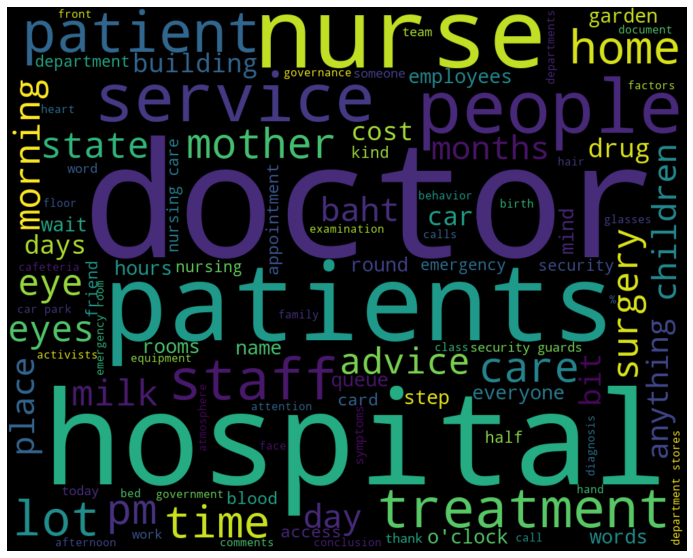

In [94]:
rajavithi_positive = get_positive_data(rajavithi)
vizwordcloud(rajavithi_positive)

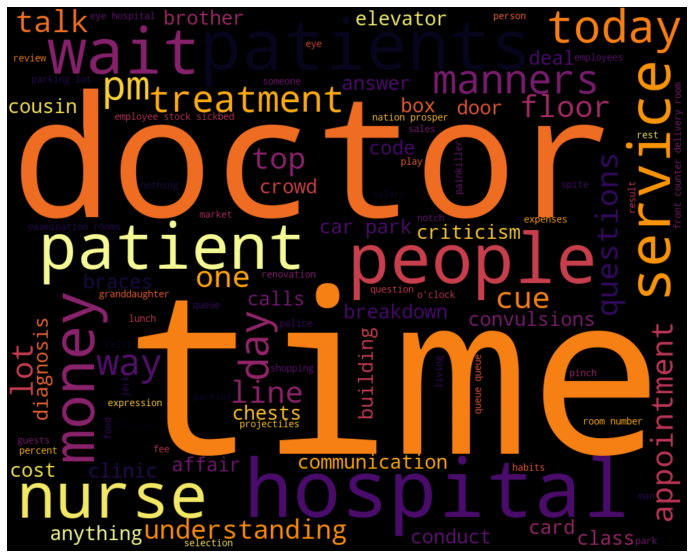

In [95]:
rajavithi_negative = get_negative_data(rajavithi)
vizwordcloud(rajavithi_negative, "inferno")